### General Concept

Given a png/jpg file of a STNK, get values of table. The png/jpg has various tilt angles and can be messy with multiple folds, marks and dirt in the paper that can occlude info

1. Use homography to find a stabilized format orientation from the tilted image
2. Use thresholding and OCR model to read specific contours from the edited image
3. Sort OCR outputs into text.

### Import Dump

In [90]:
import cv2
import pandas as pd
import numpy as np
import fitz
import matplotlib.pyplot as plt
import easyocr
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)

### PDF to PNG

In [2]:
pdf_name = "BPKB B2522PFM.pdf"

doc = fitz.open(pdf_name)

for page in doc:
    pix = page.get_pixmap(dpi=600)
    name = pdf_name[:-4] + "-page-" + str(page.number) + ".png"
    pix.save(name)

### Homography

Since the scans of the STNKs can be tilted, it is best to first tilt it to a clean original non-tilted format like the pdfs. This is so the structure of the image retains stability and structure with any tilted image. Homography is used for this.

'1'

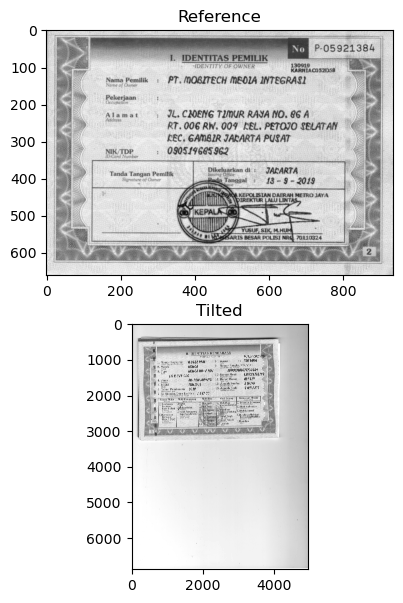

In [162]:
filename = "BPKB B2522PFM-page-1.png"

page_num = filename[-5:-4]

# read reference stable image
ref = cv2.imread("bpkb_p1.png")
ex = cv2.imread(filename)

# convert to grayscale
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ex = cv2.cvtColor(ex, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,7))

plt.subplot(211); plt.title("Reference"); plt.imshow(ref, cmap="gray")
plt.subplot(212); plt.title("Tilted"); plt.imshow(ex, cmap="gray")

Create ORBs (Orientated fast Rotated Brief) to highlight keypoints from both images

Text(0.5, 1.0, 'Example')

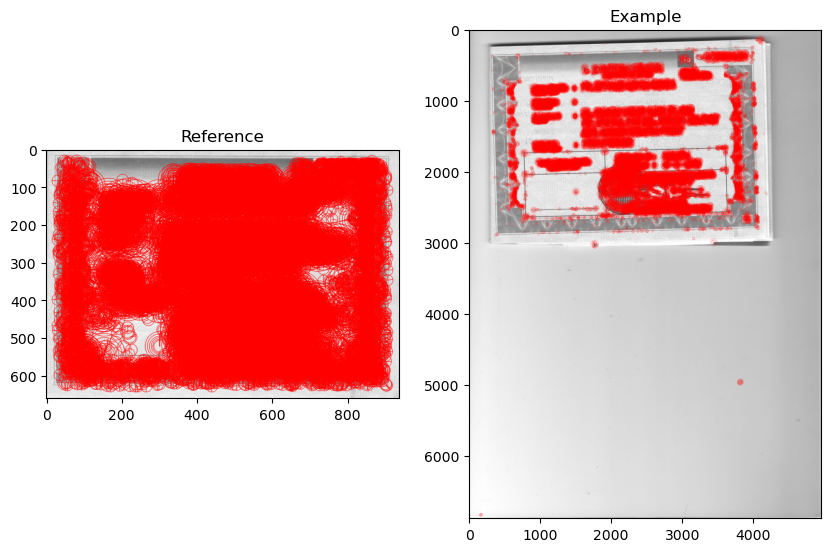

In [55]:
# create orbs (keypoints)
orb = cv2.ORB_create(50000)
ref_keypoints, ref_descs = orb.detectAndCompute(ref, None)
ex_keypoints, ex_descs = orb.detectAndCompute(ex, None)

# display orbs
ref_orbs = cv2.drawKeypoints(ref, ref_keypoints, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ex_orbs = cv2.drawKeypoints(ex, ex_keypoints, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,7))

plt.subplot(121); plt.imshow(ref_orbs); plt.title("Reference")
plt.subplot(122); plt.imshow(ex_orbs); plt.title("Example")

Find geometric relationship and mapping from both images

(-0.5, 5892.5, 6876.5, -0.5)

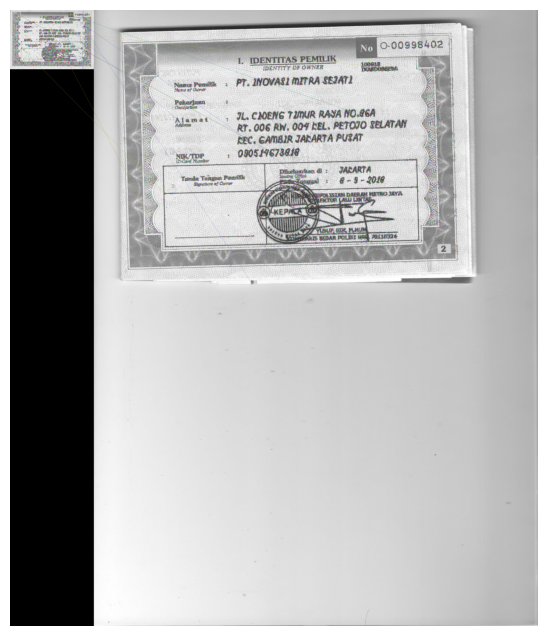

In [65]:
# create matcher
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE)

# connect descriptors
matches = list(matcher.match(ref_descs, ex_descs, None))

# sort matches by score
matches.sort(key=lambda x: x.distance)

# remove bad score matches
num_of_good_matches = int(len(matches) * 0.0005)
matches = matches[:num_of_good_matches]

# display matches
matches_img = cv2.drawMatches(ref, ref_keypoints, ex, ex_keypoints, matches, None)

plt.figure(figsize=(24,8))
plt.imshow(matches_img)
plt.axis("off")

With good mappings, create homography

In [66]:
# get locations of good matches
ref_points = np.zeros((len(matches), 2), dtype=np.float32)
ex_points = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    ref_points[i, :] = ref_keypoints[match.queryIdx].pt
    ex_points[i, :] = ex_keypoints[match.trainIdx].pt

# find homography
homo, mask = cv2.findHomography(ex_points, ref_points, cv2.RANSAC)

homo

array([[-1.95039848e-01, -1.14850752e-01,  7.19310457e+02],
       [-7.10023445e-02, -4.33488876e-02,  2.63100910e+02],
       [-2.70357899e-04, -1.61579700e-04,  1.00000000e+00]])

Warp perspective of image as defined by homography

Text(0.5, 1.0, 'Warped Example')

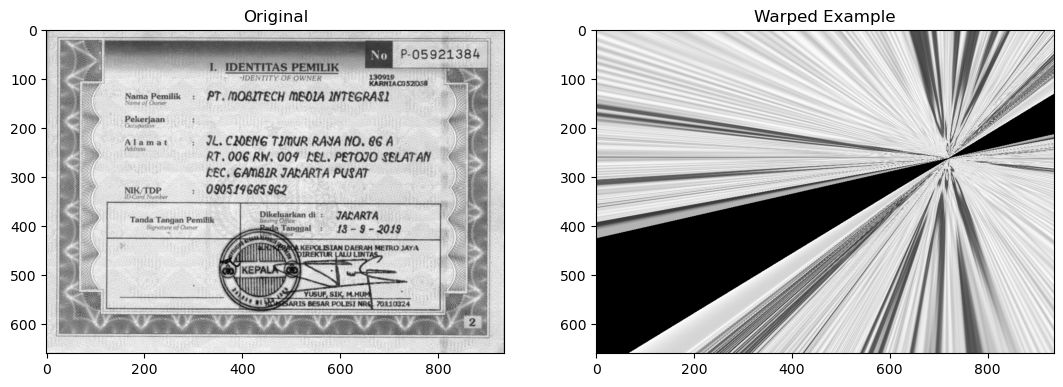

In [67]:
# warp image with homography
height, width = ref.shape
ex_warped = cv2.warpPerspective(ex, homo, (width, height))

# display result
plt.figure(figsize=[13, 10])

plt.subplot(121); plt.imshow(ref, cmap="gray"); plt.title("Original")
plt.subplot(122); plt.imshow(ex_warped, cmap="gray"); plt.title("Warped Example")

### Scanning

In [133]:
# define OCR model 
reader = easyocr.Reader(["id", "en"])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Display image to be processed at full

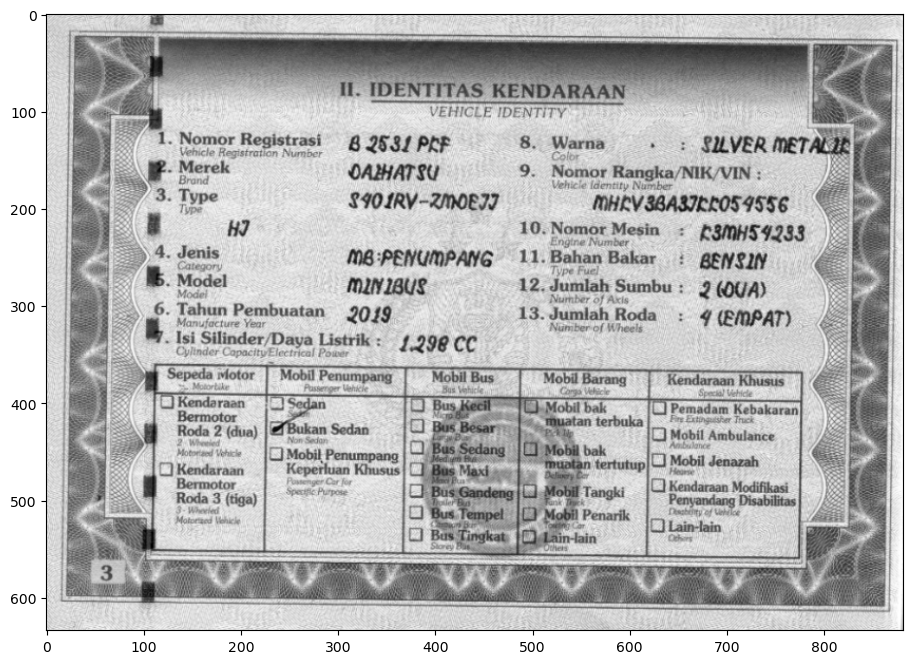

In [205]:
filename = "bpkb_p2.png"

page_num = filename[-5:-4]

bpkb = cv2.imread(filename)
bpkb = cv2.cvtColor(bpkb, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(30,8))
plt.imshow(bpkb, cmap="gray")

Create a threshold for creating pure monochrome image

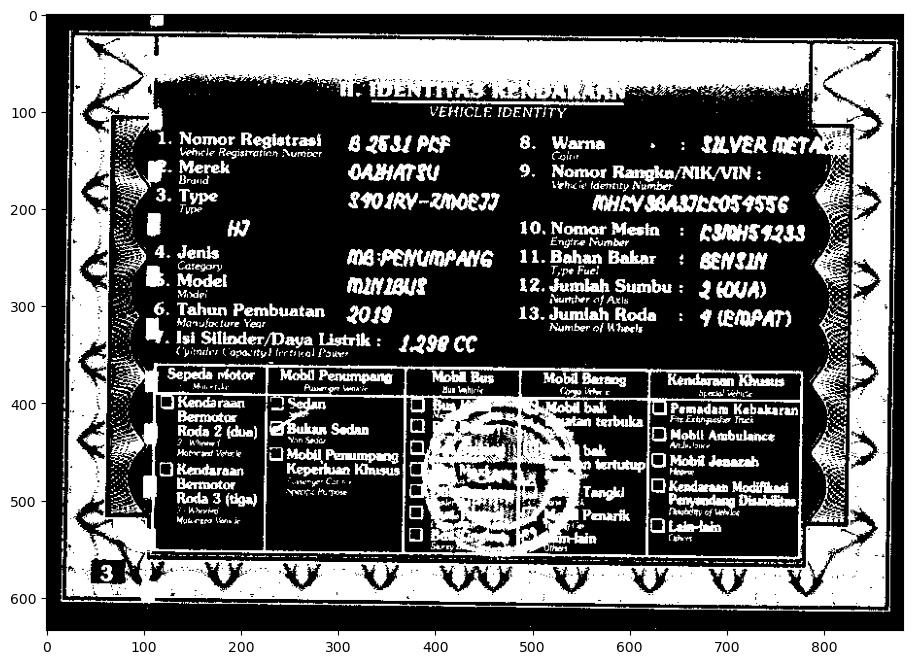

In [163]:
# make threshold image (maybe more optimal values exists)
thresh = cv2.threshold(bpkb, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# show monochrome image
plt.figure(figsize=(30,8))
plt.imshow(thresh, cmap="gray")

The ROI (region of interest) is the table at the bottom left. Therefore crop into two images of only the values of the table. The format and orientation of the image will always be like the reference image therefore using constant pixels to determine the contours for the ROI in this case is fine.

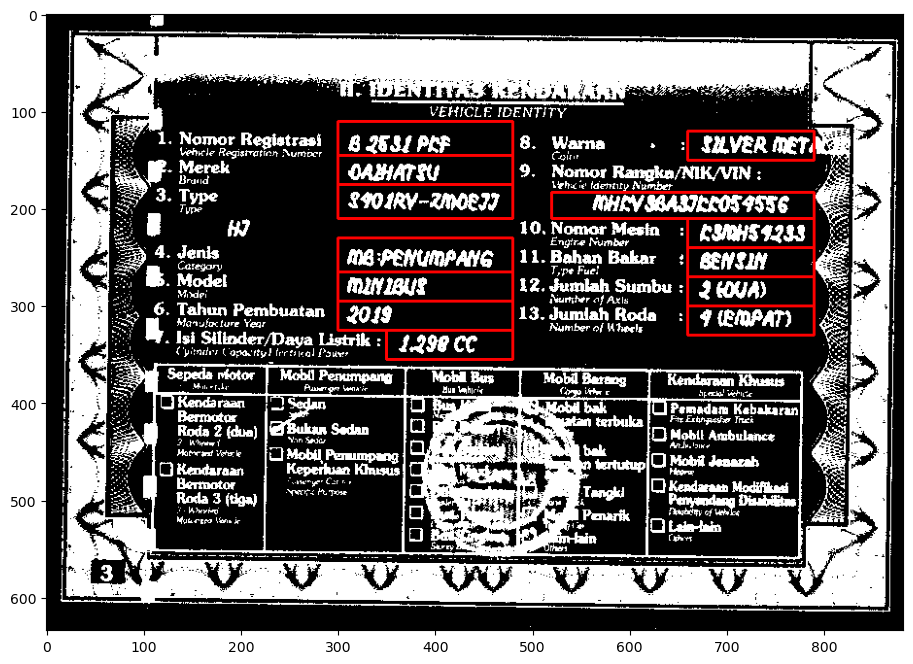

In [195]:
contour_boxes = thresh.copy()
contour_boxes = cv2.cvtColor(contour_boxes, cv2.COLOR_GRAY2BGR)

if page_num == "0":
    # Draw contours for ROI
    cv2.rectangle(contour_boxes, (310, 120), (800, 160), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (310, 160), (800, 205), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (310, 205), (800, 310), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (310, 310), (800, 350), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (580, 360), (790, 395), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (580, 395), (790, 425), (255, 0, 0), 2)
elif page_num == "1":
    cv2.rectangle(contour_boxes, (300, 110), (480, 145), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (300, 145), (480, 175), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (300, 175), (480, 210), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (300, 230), (480, 265), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (300, 265), (480, 295), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (300, 295), (480, 325), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (350, 325), (480, 355), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (660, 120), (790, 150), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (520, 183), (790, 210), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (660, 210), (790, 240), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (660, 240), (790, 270), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (660, 270), (790, 300), (255, 0, 0), 2)
    cv2.rectangle(contour_boxes, (660, 300), (790, 330), (255, 0, 0), 2)


plt.figure(figsize=(30,8))
plt.imshow(contour_boxes)

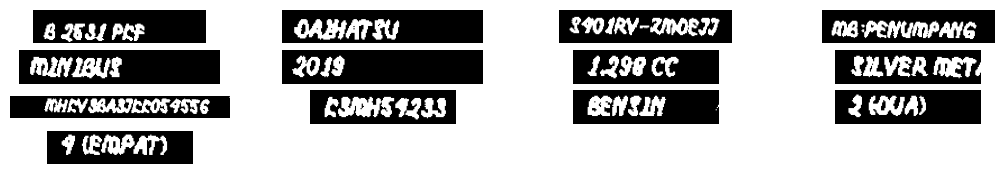

In [201]:
if page_num == "0":
    # make individual images for each contour
    v1 = thresh[120:160,310:800]
    v2 = thresh[160:205,310:800]
    v3 = thresh[205:310,310:800]
    v4 = thresh[310:350,310:800]
    v5 = thresh[360:395,580:790]
    v6 = thresh[395:425,580:790]


    plt.figure(figsize=(13, 2))

    plt.subplot(231); plt.imshow(v1, cmap="gray")
    plt.subplot(232); plt.imshow(v2, cmap="gray")
    plt.subplot(233); plt.imshow(v3, cmap="gray")
    plt.subplot(234); plt.imshow(v4, cmap="gray")
    plt.subplot(235); plt.imshow(v5, cmap="gray")
    plt.subplot(236); plt.imshow(v6, cmap="gray")
elif page_num == "1":
    v1 = thresh[110:145,300:480]
    v2 = thresh[145:175,300:480]
    v3 = thresh[175:210,300:480]
    v4 = thresh[230:265,300:480]
    v5 = thresh[265:295,300:480]
    v6 = thresh[295:325,300:480]
    v7 = thresh[325:355,350:480]
    v8 = thresh[120:150,660:790]
    v9 = thresh[183:210,520:790]
    v10 = thresh[210:240,660:790]
    v11 = thresh[240:270,660:790]
    v12 = thresh[270:300,660:790]
    v13 = thresh[300:330,660:790]

    plt.figure(figsize=(13, 2))

    plt.subplot(4,4,1); plt.imshow(v1, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,2); plt.imshow(v2, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,3); plt.imshow(v3, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,4); plt.imshow(v4, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,5); plt.imshow(v5, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,6); plt.imshow(v6, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,7); plt.imshow(v7, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,8); plt.imshow(v8, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,9); plt.imshow(v9, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,10); plt.imshow(v10, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,11); plt.imshow(v11, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,12); plt.imshow(v12, cmap="gray"); plt.axis("off")
    plt.subplot(4,4,13); plt.imshow(v13, cmap="gray"); plt.axis("off")

With the contours defined, use the model to read the contours

In [202]:
if page_num == "0":
    contours = [v1, v2, v3, v4, v5, v6]
elif page_num == "1":
    contours = [v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13]
info_col = []

for v in contours:
    # use ocr model cropped image
    scan1 = reader.readtext(v)
    text_concat = ""

    for (bbox, text, prob) in scan1:
        text_concat += text

    info_col.append(text_concat)


info_col

['8 Zg8/ PtF',
 'oahatfu',
 'PSOIRV-ZM0877',
 'M8 Penumnpafg',
 'MMzUf',
 '2018',
 '1290 CC',
 'JHVER MET',
 'Mhlysaantiosas6',
 'Gephss?ns',
 'BSHSW',
 'Koa)',
 '(empat)']

### Data Manipulation

The resultant CSV file will be per column like the one in the image

In [203]:
# get name of all rows/info
if page_num == "0":
    name_col = [
        "Nama Pemilik",
        "Pekerjaan",
        "Alamat",
        "NIK",
        "Keluaraan",
        "Tanggal"
    ]
elif page_num == "1":
    name_col = [
        "Nomor Registrasi",
        "Merek",
        "Type",
        "Jenis",
        "Model",
        "Tahun Pembuatan",
        "Isi Silinder",
        "Warna",
        "Nomor Rangka",
        "Nomor Mesin",
        "Bahan Bakar",
        "Jumlah Sumbu",
        "Jumlah Roda"
    ]

In [204]:
# put both lists into dataframe
info = pd.DataFrame({
    "Name": name_col,
    "Info": info_col
})

info

,Name,Info
0,Nomor Registrasi,8 Zg8/ PtF
1,Merek,oahatfu
2,Type,PSOIRV-ZM0877
3,Jenis,M8 Penumnpafg
4,Model,MMzUf
5,Tahun Pembuatan,2018
6,Isi Silinder,1290 CC
7,Warna,JHVER MET
8,Nomor Rangka,Mhlysaantiosas6
9,Nomor Mesin,Gephss?ns


In [206]:
# export dataframe to csv file
csv_name = filename[:-4] + "_info.csv"
info.to_csv(csv_name, index=False)